# We are simulating calcium transients with shot noise.



## Core functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_transient(params_sensor, params_experiment):
    """
    simulates a calcium transient with given rise, decay and df/f amplitude (params_sensor) 
    and adds shot noise (params_experiment)
    The transient is always "sampled" at 1 kHz, for simplicity.
    """
    t = np.arange(0,25,.001)# ms 
    offset = 25000
    t_real = np.arange(-.001*offset,25,.001)
    tau_rise = params_sensor['tau_rise']
    tau_decay = params_sensor['tau_decay']
    amplitude = params_sensor['amplitude']
    baseline_photon_count = params_experiment['baseline_photon_count']
    noise_photon_count = params_experiment['noise_photon_count']
    color = params_sensor['color']
    rise = 1- np.exp(t/tau_rise*-1)
    decay = np.exp(t/-tau_decay)
    transient = rise*decay
    transient = transient/np.max(transient)
    peak_t = np.argmax(transient)
    half_peak_t = np.argmax(transient>.5)
    half_decay_t = np.argmax(transient[peak_t:]<.5)
    transient = np.concatenate([np.zeros(offset),transient])
    transient = amplitude*transient
    transient_photons = (transient*baseline_photon_count)+baseline_photon_count + noise_photon_count
    noisy_transient_photons = np.random.poisson(transient_photons)
    noisy_transient = (noisy_transient_photons-baseline_photon_count)/baseline_photon_count
    dict_out = {'transient': transient,
               'transient_photons':transient_photons,
               'noisy_transient':noisy_transient,
               'noisy_transient_photons':noisy_transient_photons,
               't':t_real,
               'peak_t':peak_t,
               'half_peak_t':half_peak_t,
               'half_decay_t':half_decay_t,
                'color':color}
    return dict_out

def calculate_d_prime_for_trace(params_sensor,params_experiment,sampling_rate,samples_to_average,repeats):
    """
    Calculates d' for a given sensor/noise/sampling rate/averaging.
    We use the knowledge of rise/decay times and sampling rate to sample the part of the transient with the highest amplitude.
    The original transient is sampled @1kHz and then resampled at the desired frequency with all the possible offsets
    when calculating d'.
    This script calculates noisy amplitudes first, then calculates the d' from it. The repeats variable controls the 
    minimum number of amplitudes used for estimating d'.
    """
    transient_dict = simulate_transient(params_sensor, params_experiment)
    peak_window_center = np.argmax(np.convolve(transient_dict['transient'],np.ones(si*samples_to_average),'same')) # find the peak of the transient with the given SR
    peak_window_start = peak_window_center-int(si/2)
    amplitudes_all = []
    while len(amplitudes_all)<repeats:
        transient_dict = simulate_transient(params_sensor, params_experiment)
        baselines_list = []
        peaks_list = []
        for sample in range(samples_to_average):
            baselines_list.append(transient_dict['noisy_transient_photons'][sample*si:sample*si+si])
            peaks_list.append(transient_dict['noisy_transient_photons'][peak_window_start+sample*si:sample*si+peak_window_start+si])
        baselines = np.mean(baselines_list,0)
        peaks =np.mean(np.asarray(peaks_list),0)
        amplitudes = peaks-baselines
        amplitudes_all.extend(amplitudes)
    dprime = np.mean(amplitudes_all)/np.sqrt(np.var(amplitudes_all)/2)
    return dprime

## Set the parameters of each sensor

(-0.5, 1.5)

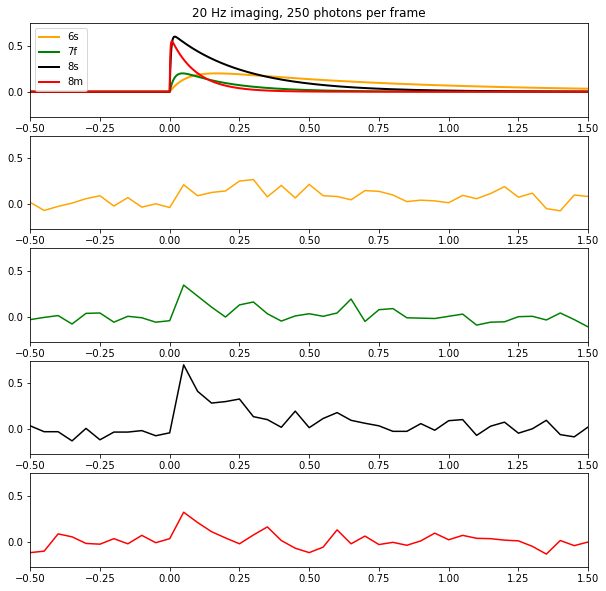

In [2]:

parameters = {'6s':{'tau_rise':.07,
                    'tau_decay':.7,
                    'amplitude':0.2,
                    'color':'orange'},
              '7f':{'tau_rise':.02,
                    'tau_decay':.18,
                    'amplitude':.2,
                    'color':'green'},
              '8s':{'tau_rise':.0045,
                    'tau_decay':.25,
                    'amplitude':0.6,
                    'color':'black'},
              '8m':{'tau_rise':.002,
                    'tau_decay':.09,
                    'amplitude':0.55,
                    'color':'red'}}

params_experiment  = {'baseline_photon_count':10,
                     'noise_photon_count':0}
photons_per_s = 5000

example_sampling_rate = 20
fig_transients = plt.figure(figsize = [10,10])
ax_transients = fig_transients.add_subplot(len(parameters.keys())+1,1,1)
for sensor_i,sensor in enumerate(parameters.keys()):
    params_sensor = parameters[sensor]
    params_experiment['baseline_photon_count'] = photons_per_s/example_sampling_rate
    transient_dict = simulate_transient(params_sensor, params_experiment)
    ax_transients.plot(transient_dict['t'],transient_dict['transient'],color = transient_dict['color'],label = sensor,linewidth = 2)
    ax_noisy_transients = fig_transients.add_subplot(len(parameters.keys())+1,1,sensor_i+2,sharey = ax_transients,sharex = ax_transients)
    ax_noisy_transients.plot(transient_dict['t'][::int(1000/example_sampling_rate)],transient_dict['noisy_transient'][::int(1000/example_sampling_rate)],color = transient_dict['color'],alpha = 1)
ax_transients.legend() 
ax_transients.set_title('{} Hz imaging, {} photons per frame'.format(example_sampling_rate,int(photons_per_s/example_sampling_rate)))
ax_transients.set_xlim([-.5, 1.5])

## How does framerate affect d'? 
We keep the photon count per frame constant, and increase the framerate

Text(0, 0.5, 'd-prime')

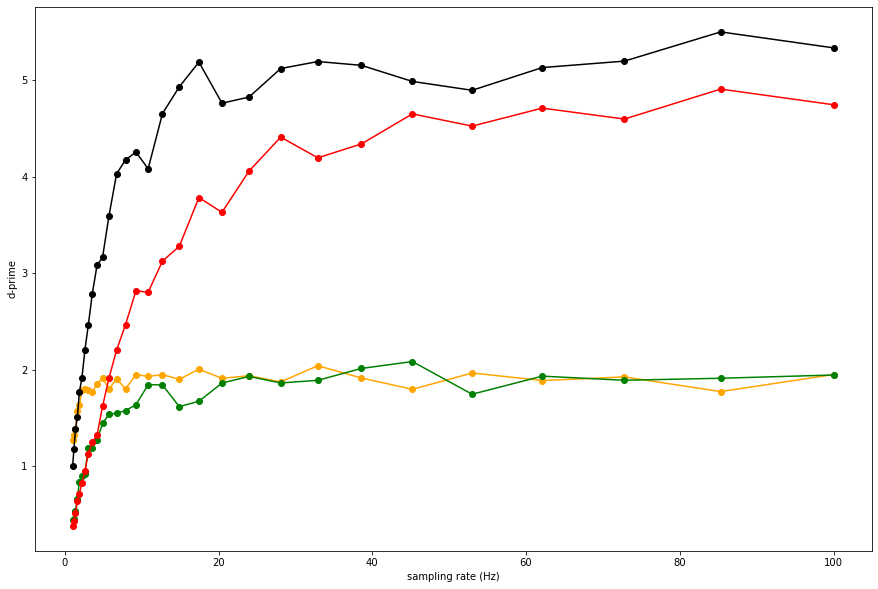

In [3]:
fig_freq_dprime = plt.figure(figsize = [15,10])
ax_freq_dprime = fig_freq_dprime.add_subplot(1,1,1)
sampling_rate_list = np.logspace(0,2,30)#np.arange(1,20,1)
samples_to_average = 1
repeats = 500
params_experiment['baseline_photon_count'] = 100
dprime_ax_list = []
for sensor_i,sensor in enumerate(parameters.keys()):
    params_sensor = parameters[sensor]
    dprime_list = []
    for sr_i,sampling_rate in enumerate(sampling_rate_list):
        
        si = int(1000/sampling_rate)
        dprime = calculate_d_prime_for_trace(params_sensor,params_experiment,sampling_rate,samples_to_average,repeats)
        dprime_list.append(dprime)
    ax_freq_dprime.plot(sampling_rate_list,dprime_list,'-o',color = params_sensor['color'])
    
    
ax_freq_dprime.set_xlabel('sampling rate (Hz)')
ax_freq_dprime.set_ylabel('d-prime')

This is equivalent to zooming in and increasing framerate but with the same power. </br>
Next, to be more realistic, we keep the photon rate constant, meaning in an experiment that we are using the same zoom factor, and when increasing the framerate we have a shorter dwell time per cell, that will result in fewer photons.
In this example we use a photon rate of 1000/s, which is the best we can get for our 6s mice for 1.2x magnification, 30mW power.

Text(0, 0.5, 'd-prime')

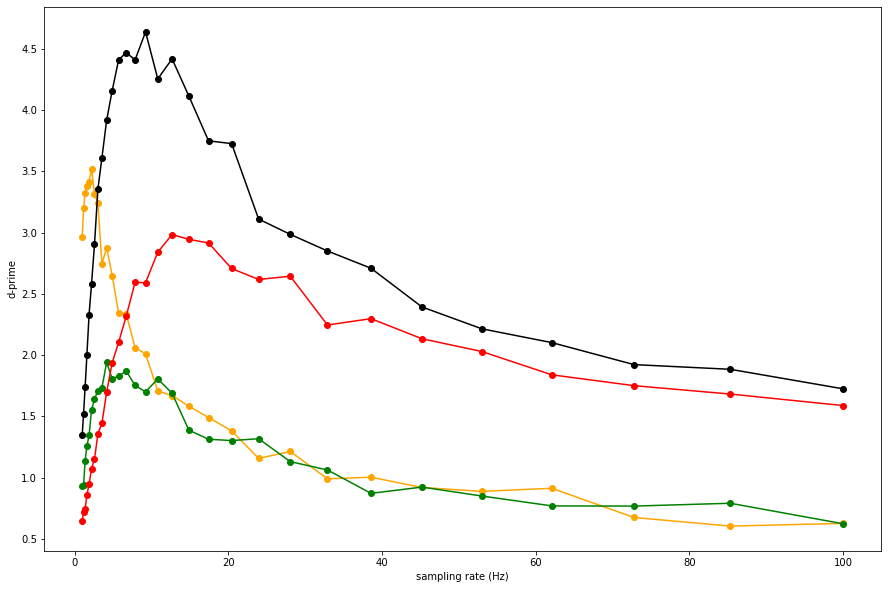

In [4]:
fig_freq_dprime = plt.figure(figsize = [15,10])
ax_freq_dprime = fig_freq_dprime.add_subplot(1,1,1)
sampling_rate_list = np.logspace(0,2,30)#np.arange(1,20,1)
samples_to_average = 1
repeats = 500
photons_per_s = 1000

dprime_ax_list = []
for sensor_i,sensor in enumerate(parameters.keys()):
    params_sensor = parameters[sensor]
    dprime_list = []
    for sr_i,sampling_rate in enumerate(sampling_rate_list):
        params_experiment['baseline_photon_count'] = photons_per_s/sampling_rate
        si = int(1000/sampling_rate)
        dprime = calculate_d_prime_for_trace(params_sensor,params_experiment,sampling_rate,samples_to_average,repeats)
        dprime_list.append(dprime)
    ax_freq_dprime.plot(sampling_rate_list,dprime_list,'-o',color = params_sensor['color'])
    
    
ax_freq_dprime.set_xlabel('sampling rate (Hz)')
ax_freq_dprime.set_ylabel('d-prime')

Similarly, one can do post-hoc averaging after recording a movie at a given framerate. 

Text(0, 0.5, 'd-prime')

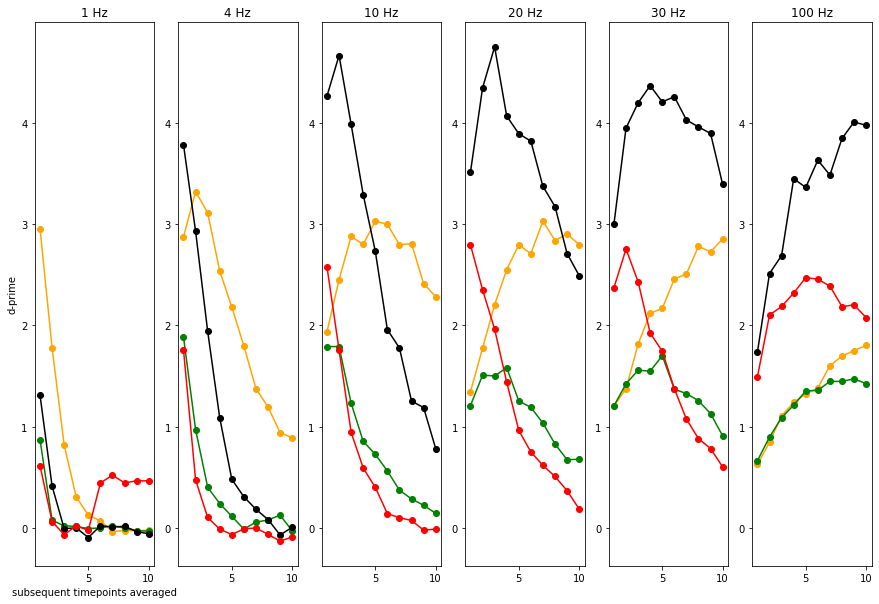

In [5]:

fig_dprime = plt.figure(figsize = [15,10])
sampling_rate_list = [1,4,10,20,30,100]
photons_per_s = 1000
samples_to_average_list = [1,2,3,4,5,6,7,8,9,10]
repeats = 500

dprime_ax_list = []
for sensor_i,sensor in enumerate(parameters.keys()):
    params_sensor = parameters[sensor]
    for sr_i,sampling_rate in enumerate(sampling_rate_list):
        params_experiment['baseline_photon_count'] = photons_per_s/sampling_rate
        si = int(1000/sampling_rate)
        if sensor_i ==0 :
            if sr_i == 0:
                dprime_ax_list.append(fig_dprime.add_subplot(1,len(sampling_rate_list),sr_i+1))
            else:
                dprime_ax_list.append(fig_dprime.add_subplot(1,len(sampling_rate_list),sr_i+1,sharex= dprime_ax_list[0],sharey = dprime_ax_list[0]))
            dprime_ax_list[sr_i].set_title('{} Hz'.format(sampling_rate))
        dprime_list = []
        for samples_to_average in samples_to_average_list:
            dprime = calculate_d_prime_for_trace(params_sensor,params_experiment,sampling_rate,samples_to_average,repeats)
            dprime_list.append(dprime)
        dprime_ax_list[sr_i].plot(samples_to_average_list,dprime_list,'-o',color = params_sensor['color'])
    
    #print('{} - rise: {}, half_rise: {}, half_decay: {}, integral: {},dprime {}, noise: {}'.format(sensor,peak_t, half_peak_t,half_decay_t,np.sum(transient),dprime,np.std(noisy_transient_photons[:offset])))

    
dprime_ax_list[0].set_xlabel('subsequent timepoints averaged')
dprime_ax_list[0].set_ylabel('d-prime')
